In [ ]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gdown
output = "/content/drive/My Drive/Q2/glove.6B.zip"
gdown.download("https://nlp.stanford.edu/data/glove.6B.zip", output, quiet=False)

Downloading...
From: https://nlp.stanford.edu/data/glove.6B.zip
To: /content/drive/My Drive/Q2/glove.6B.zip
100%|██████████| 862M/862M [02:38<00:00, 5.44MB/s]


'/content/drive/My Drive/Q2/glove.6B.zip'

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/Q2/glove.6B.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/My Drive/Q2/")

In [ ]:
new_df = pd.read_csv('/content/drive/My Drive/Q2/FA-KES-Dataset.csv', encoding= 'unicode_escape')


In [ ]:

column_n = ['unit_id',	'article_title',	'article_content',	'source',	'date'	,'location',	'labels']
remove_c = ['unit_id',	'article_title','source',	'date'	,'location']
categorical_features = []
target_col = ['labels']
text_f = ['article_content']
# Clean Datasets
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Removed unused clumns
def remove_unused_c(df,column_n=remove_c):
    df = df.drop(column_n,axis=1)
    return df

# Impute null values with None
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)
    #impute null values
    df = null_process(df)
    return df


def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  
    return text


def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:

df = clean_dataset(new_df)
df["article_content"] = df.article_content.apply(nltk_preprocess)



In [ ]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['article_content'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(df['article_content'])
padded = pad_sequences(sequences, maxlen=300, padding='post')

10416


In [ ]:
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['labels'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['labels'].values[split_n:]

In [ ]:
embeddings_index = {};
with open('/content/drive/My Drive/Q2/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

100


In [ ]:
     
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
     

In [ ]:

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         1041700   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,126,469
Trainable params: 84,769
Non-trainable params: 1,041,700
_______________________________________

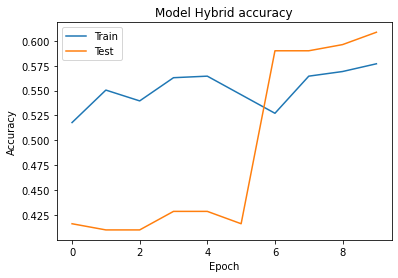

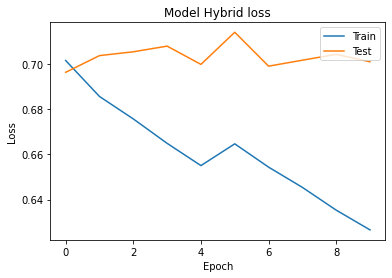

In [ ]:

# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Hybrid accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Hybrid loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
y_pred = model.predict(test_data)
print(classification_report(test_labels,tf.argmax(y_pred, axis=1)))

6/6 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        67
           1       0.00      0.00      0.00        94

    accuracy                           0.42       161
   macro avg       0.21      0.50      0.29       161
weighted avg       0.17      0.42      0.24       161



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **RNN**

In [ ]:
     
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
     

In [ ]:

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         1041700   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,045,989
Trainable params: 4,289
Non-trainable params: 1,041,700
_________________________________________________________________
Epoch 1/10
11/11 [==============================] - 2s 95ms/step - loss: 0.7140 - accuracy: 0.4914 - val_loss: 0.6964 - val_accuracy: 0.5963
Epoch 2/10
11/11 [==============================] - 1s 70ms/step - loss: 0.6957 - accuracy: 0.5117 - val_loss: 0.6951 - val_accuracy: 0.5528
Epoch 3/10
11/11 [====

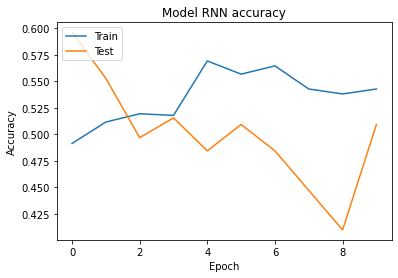

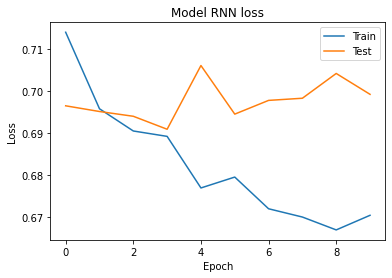

In [ ]:

# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model RNN accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model RNN loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
y_pred = model.predict(test_data)
print(classification_report(test_labels,tf.argmax(y_pred, axis=1)))

6/6 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        67
           1       0.00      0.00      0.00        94

    accuracy                           0.42       161
   macro avg       0.21      0.50      0.29       161
weighted avg       0.17      0.42      0.24       161



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
